# Solar Panel Data Analysis

## File Format

In [5]:
import gzip, shutil

In [6]:
# Compress CSV file for upload
with open('solar_data.csv', 'rb') as f_in:
    with gzip.open('solar_data.csv.gz', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

In [7]:
# Decompress CSV for processing
with gzip.open('solar_data.csv.gz', 'rb') as f_in:
    with open('solar_data.csv', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

In [8]:
with open('solar_data.csv') as f:
    for i in range(4):
        print(f.readline(), end='')
    for s in f:
        i += 1
print('••• ({:d} - 4 lines)\n{:s}'.format(i, s), end='')

"Date & Time","Usage [kWh]","Generation [kWh]","Grid [kWh]","Solar [kWh]","Solar+ [kWh]"
2017-09-23 14:00:00,5398.379564444,5907.685191667,-556.027505000,5907.685191667,5954.407069444
2017-09-23 13:59:00,5398.332943333,5907.629288611,-556.018223056,5907.629288611,5954.351166389
2017-09-23 13:58:00,5398.286305000,5907.573029167,-556.008601944,5907.573029167,5954.294906944
••• (525928 - 4 lines)
2016-09-21 17:00:00,-283.494235278,-37.552713889,-284.370767222,-37.552713889,0.876531944


In [2]:
import pandas

In [3]:
df = pandas.read_csv('solar_data.csv', parse_dates=['Date & Time'])

In [4]:
df.take([0,1,2,-1])

,Date & Time,Usage [kWh],Generation [kWh],Grid [kWh],Solar [kWh],Solar+ [kWh]
0,2017-09-23 14:00:00,5398.379564,5907.685192,-556.027505,5907.685192,5954.407069
1,2017-09-23 13:59:00,5398.332943,5907.629289,-556.018223,5907.629289,5954.351166
2,2017-09-23 13:58:00,5398.286305,5907.573029,-556.008602,5907.573029,5954.294907
525927,2016-09-21 17:00:00,-283.494235,-37.552714,-284.370767,-37.552714,0.876532


In [5]:
i = df['Generation [kWh]'] - df['Solar [kWh]']
i.max()

0.0

In [6]:
i = df['Usage [kWh]'] - df['Solar+ [kWh]'] - df['Grid [kWh]']
i.max()

1.0014673534897156e-09

In [7]:
i = df['Solar+ [kWh]'] - df['Solar [kWh]']
i.min(), i.mean(), i.max()

(38.429245833000003, 42.896849498967505, 46.721877778000817)

In [8]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

%matplotlib inline

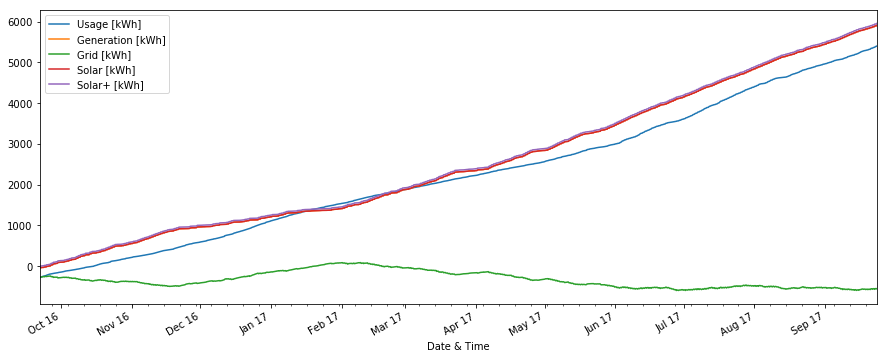

In [9]:
df.set_index('Date & Time',inplace=True)
fig, ax = plt.subplots(figsize=(15,6))
df.plot(ax=ax)

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))
ax.xaxis.set_minor_locator(mdates.WeekdayLocator())

## Polar Plots

In [10]:
def day2polar(dt):
    t = dt.timetuple()
    i = (t.tm_hour*60 + t.tm_min)*60 + t.tm_sec
    return 2*pandas.np.pi * i / (24*3600)

def year2polar(dt):
    t = dt.timetuple()
    if t.tm_yday > 182:
        return 366 - t.tm_yday
    else:
        return t.tm_yday

In [11]:
pandas.np.pi, df.index[0].timetuple()

(3.141592653589793,
 time.struct_time(tm_year=2017, tm_mon=9, tm_mday=23, tm_hour=14, tm_min=0, tm_sec=0, tm_wday=5, tm_yday=266, tm_isdst=-1))

In [12]:
#df['Time'] = df.index.time
df['Time [rad]'] = df.index.map(day2polar)

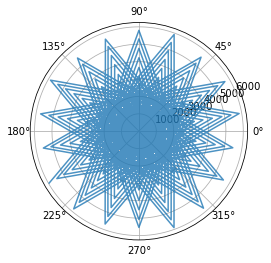

In [13]:
#p = df.plot.pie('Date & Time', 'Solar+ [kWh]', figsize=(12,6))
ax = plt.subplot(111, projection='polar')
i=2000
ax.plot(df['Time [rad]'][::i], df['Solar+ [kWh]'][::i], alpha=0.8)

## Solar Generation and Usage

In [14]:
#i = df['Solar+ [kWh]'].rolling(2)
df['Solar'] = df['Solar [kWh]'].diff(-1)
df['Usage'] = df['Usage [kWh]'].diff(-1)
df['Loss'] = df['Solar+ [kWh]'].diff(-1) - df['Solar']

In [15]:
df2 = df.drop('Usage [kWh],Generation [kWh],Grid [kWh],Solar [kWh],Solar+ [kWh],Time [rad]'.split(','), axis=1)
df2.columns

Index(['Solar', 'Usage', 'Loss'], dtype='object')

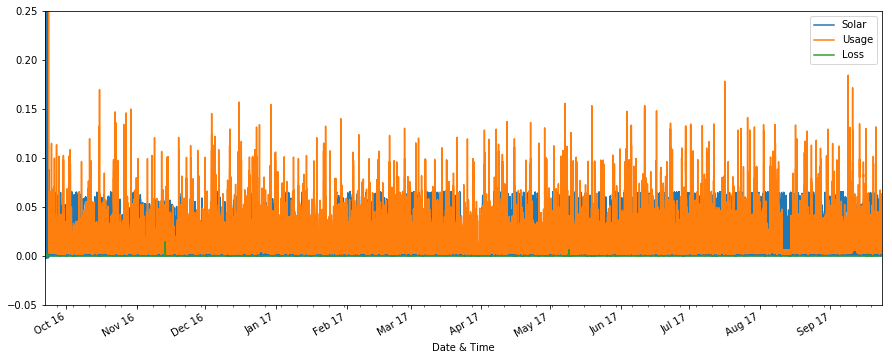

In [16]:
fig, ax = plt.subplots(figsize=(15,6))
df2.plot(ax=ax, ylim=(-0.05,0.25))

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))
ax.xaxis.set_minor_locator(mdates.WeekdayLocator())
#ax.yaxis.set_data_interval(-0.5,0.5)

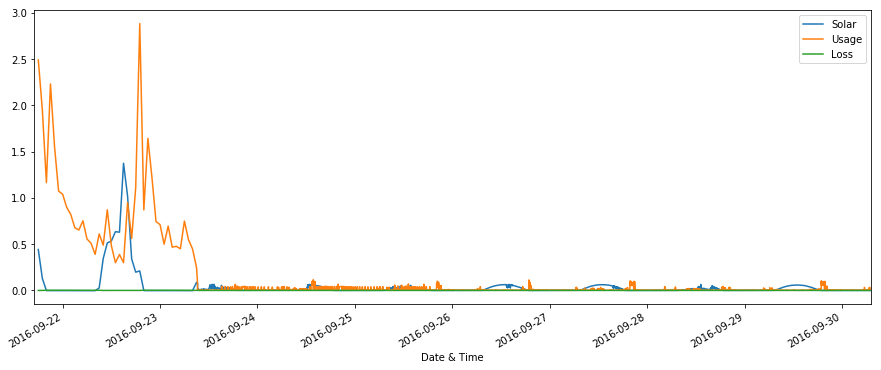

In [17]:
fig, ax = plt.subplots(figsize=(15,6))
df2.iloc[-10000:].plot(ax=ax)

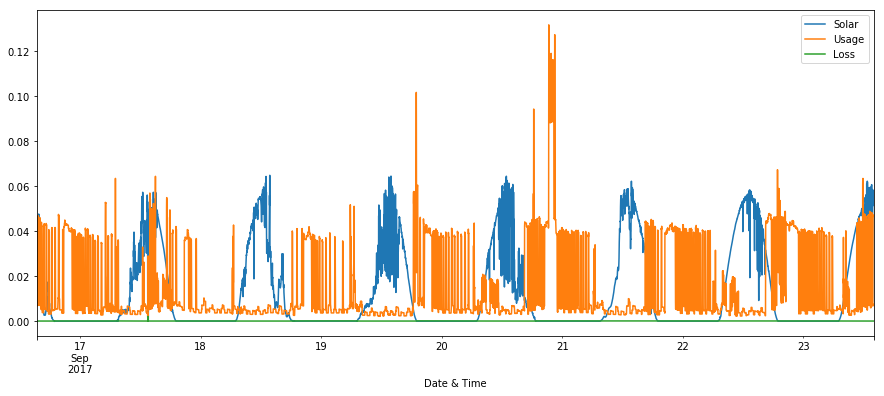

In [18]:
fig, ax = plt.subplots(figsize=(15,6))
df2.iloc[:10000].plot(ax=ax)
plt.gca().invert_xaxis()

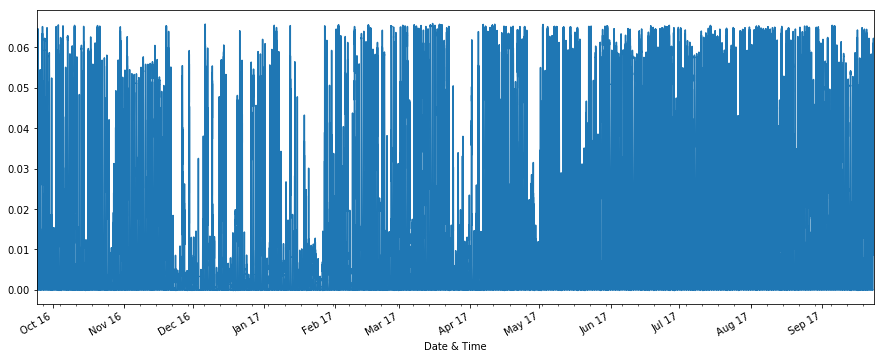

In [19]:
df3 = df2['09/24/2016':'09/23/2017']
fig, ax = plt.subplots(figsize=(15,6))
df3['Solar'].plot(ax=ax)

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))
ax.xaxis.set_minor_locator(mdates.WeekdayLocator())

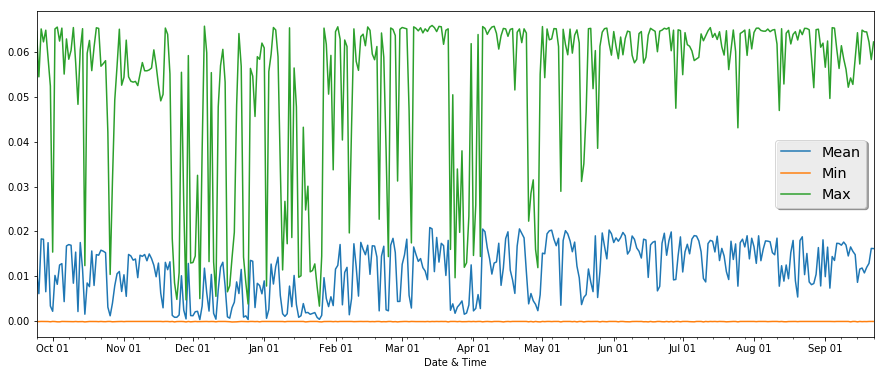

In [50]:
fig, ax = plt.subplots(figsize=(15,6))
df4 = df3.groupby(pandas.TimeGrouper('D'))
df4['Solar'].mean().plot(ax=ax, label='Mean')
df4['Solar'].min().plot(ax=ax, label='Min')
df4['Solar'].max().plot(ax=ax, label='Max')

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.xaxis.set_minor_locator(mdates.WeekdayLocator())
legend = ax.legend(shadow=True, fontsize='x-large')

## Solar Generation over the day

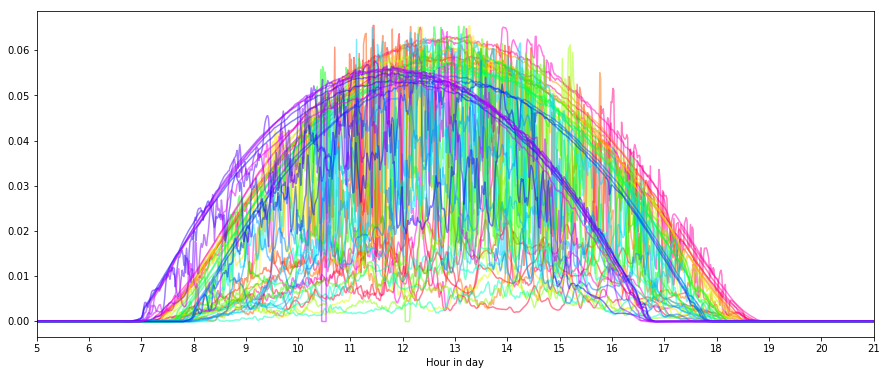

In [20]:
fig, ax = plt.subplots(figsize=(15,6))
cm = plt.get_cmap('hsv')
for i, d in enumerate(pandas.date_range('09/24/2016', periods=52, f='W')):
    # grab series
    s = df3[d.strftime('%D')]['Solar']
    # convert datetime to time of day
    t = s.index - d
    # 96 days between summer solstice (June 20) and start date
    ax.plot(t.total_seconds()/3600, s.values, alpha=0.5, c=cm((i+44)/52.0 % 1))
    
plt.xlim(5,21)
plt.xticks(tuple(range(5,21+1,1)))
plt.xlabel('Hour in day')

In [21]:
dst16 = pandas.date_range('03/13/2016','11/6/2016', freq='D')
dst17 = pandas.date_range('03/12/2017','11/5/2017', freq='D')
dst16

DatetimeIndex(['2016-03-13', '2016-03-14', '2016-03-15', '2016-03-16',
               '2016-03-17', '2016-03-18', '2016-03-19', '2016-03-20',
               '2016-03-21', '2016-03-22',
               ...
               '2016-10-28', '2016-10-29', '2016-10-30', '2016-10-31',
               '2016-11-01', '2016-11-02', '2016-11-03', '2016-11-04',
               '2016-11-05', '2016-11-06'],
              dtype='datetime64[ns]', length=239, freq='D')

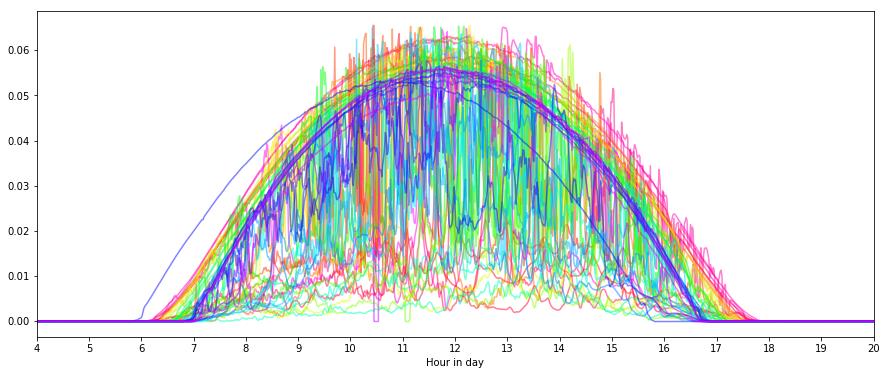

In [133]:
def plotDailySolar(dataframe, frequency='D', colormap='hsv', k='Solar'):
    fig, ax = plt.subplots(figsize=(15,6))
    cm = plt.get_cmap(colormap)
    p = {'D':365,'W':52}
    offset = {'D':96,'W':44}
    alpha = {'D':0.2, 'W':0.5}
    for i, d in enumerate(pandas.date_range('09/24/2016', periods=p[frequency], f=frequency)):
        # grab series
        s = dataframe[d.strftime('%D')][k]
        # convert datetime to time of day
        t = s.index - d
        # adjust for daylight savings
        if d in dst16 or d in dst17:
            hr = 1
        else: # not in daylight savings
            hr = 0
        c = cm((i+offset[frequency])*1.0/p[frequency] % 1)
        ax.plot(t.total_seconds()/3600 - hr, s.values, alpha=alpha[frequency], c=c)

    plt.xlim(4,20)
    plt.xticks(tuple(range(4,20+1,1)))
    plt.xlabel('Hour in day')
    return ax
    
plotDailySolar(df3, 'W')

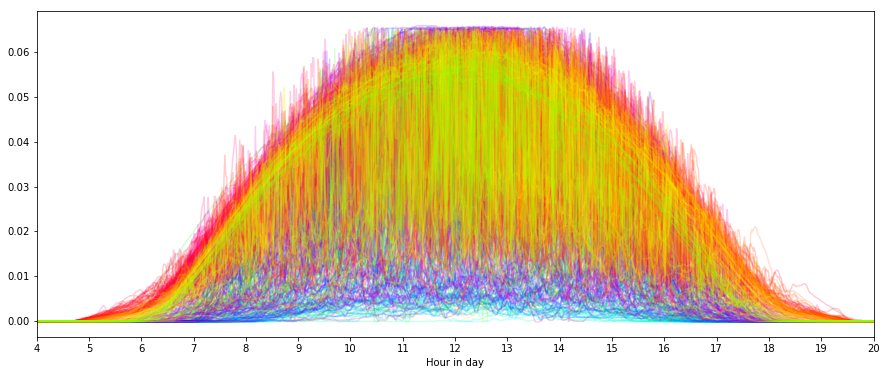

In [23]:
ax = plotDailySolar(df3)

## Solar Generation over the year

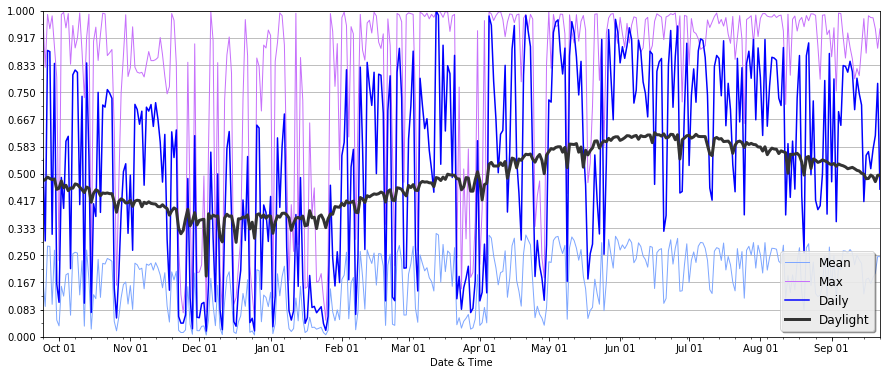

In [130]:
fig, ax = plt.subplots(figsize=(15,6))
df4 = df3.groupby(pandas.TimeGrouper('D'))
df4['Solar [norm]'].mean().plot(ax=ax, label='Mean', c='#7fa7ff', linewidth=1)
df4['Solar [norm]'].max().plot(ax=ax, label='Max', c='#c771fc', linewidth=1)
solar_max = df4['Solar'].sum()
solar_max.apply(lambda x: x / solar_max.max()).plot(ax=ax, label='Daily', c='blue')
df4['Solar [norm]'].apply(lambda column: (column > 0).sum() / len(column)).plot(ax=ax, label='Daylight', linewidth=3, c='#333333')

plt.ylim(0,1)
ax.set_yticks(pandas.np.linspace(0,1,12+1), False)
ax.set_yticks(pandas.np.linspace(0,1,24+1),True)
ax.grid(which='major', axis='y')

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.xaxis.set_minor_locator(mdates.WeekdayLocator())
legend = ax.legend(loc='lower right', shadow=True, fontsize='large')

|Date|June 20|cumulative|Dec 20|cumulative|delta|
|---|---|---|---|---|---|
|Night|04:20|04:20|11:31|11:31|07:11|
|Astronomical Twilight|01:48|06:08|01:08|12:39|00:40|
|Nautical Twilight|01:29|07:37|01:10|13:49|00:19|
|Civil Twilight|01:09|08:46|01:04|14:53|00:05|
|Daylight|15:14|24:00|09:07|24:00|-06:07|

In [204]:
def percent_daylight(t, twilight=''):
    """Given a pandas Timestamp, calculate the percentage of daylight in a 24 hour period.
Can optionally include the duration of "Civil", "Nautical", or "Astronomical" twilight."""
    solstice = pandas.Timestamp('2015-06-20')
    year = pandas.Timedelta('365 days 06:00:00')
    scale = 2 * pandas.np.pi
    day_fraction = lambda v: pandas.Timedelta(v+':00') / pandas.Timedelta('1 day')
    # HH:MM length of night at summer solstice
    d={'Civil':'01:09','Nautical':'01:29','Astronomical':'01:48'}
    base = {k:day_fraction(v) for k,v in d.items()}
    # HH:MM delta between solstices
    d={'Civil':'00:05','Nautical':'00:19','Astronomical':'00:40'}
    delta = {k:day_fraction(v) for k,v in d.items()}
    # Calculate time in year, 0 = winter solstice, 1 = summer solstice
    i = pandas.np.cos((t - solstice)/year * scale) * 0.5 + 0.5
    # Calculate daylight
    j = i * day_fraction('06:07') + day_fraction('09:07')
    if twilight:
        j += i * delta[twilight] + base[twilight]
    return j

for d in pandas.date_range('09/24/2016',periods=12,freq='M'):
    print(d, percent_daylight(d))

2016-09-30 00:00:00 0.482380810096
2016-10-31 00:00:00 0.42230945294
2016-11-30 00:00:00 0.386519633875
2016-12-31 00:00:00 0.382623032289
2017-01-31 00:00:00 0.413347719806
2017-02-28 00:00:00 0.463922493999
2017-03-31 00:00:00 0.530857471249
2017-04-30 00:00:00 0.589586641131
2017-05-31 00:00:00 0.627619646791
2017-06-30 00:00:00 0.632649121575
2017-07-31 00:00:00 0.603605410746
2017-08-31 00:00:00 0.547814747926


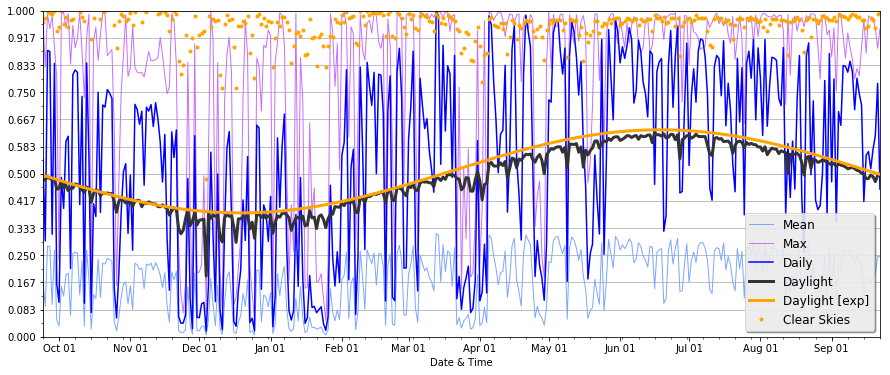

In [242]:
fig, ax = plt.subplots(figsize=(15,6))
df4 = df3.groupby(pandas.TimeGrouper('D'))
df4['Solar [norm]'].mean().plot(ax=ax, label='Mean', c='#7fa7ff', linewidth=1)
df4['Solar [norm]'].max().plot(ax=ax, label='Max', c='#c771fc', linewidth=1)
solar_max = df4['Solar'].sum()
solar_max.apply(lambda x: x / solar_max.max()).plot(ax=ax, label='Daily', c='blue')
x = df4['Solar [norm]'].apply(lambda column: (column > 0).sum() / len(column))
x.plot(ax=ax, label='Daylight', linewidth=3, c='#333333')
df4['Daylight [exp]'].mean().plot(ax=ax, label='Daylight [exp]', linewidth=3, c='orange')
(x / df3['Daylight [exp]']).dropna().plot(ax=ax, label='Clear Skies', marker='.', linewidth=0, c='orange')

plt.ylim(0,1)
ax.set_yticks(pandas.np.linspace(0,1,12+1), False)
ax.set_yticks(pandas.np.linspace(0,1,24+1),True)
ax.grid(which='major', axis='y')

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.xaxis.set_minor_locator(mdates.WeekdayLocator())
legend = ax.legend(loc='lower right', shadow=True, fontsize='large')

## Electricity Usage over the day

(0, 24)

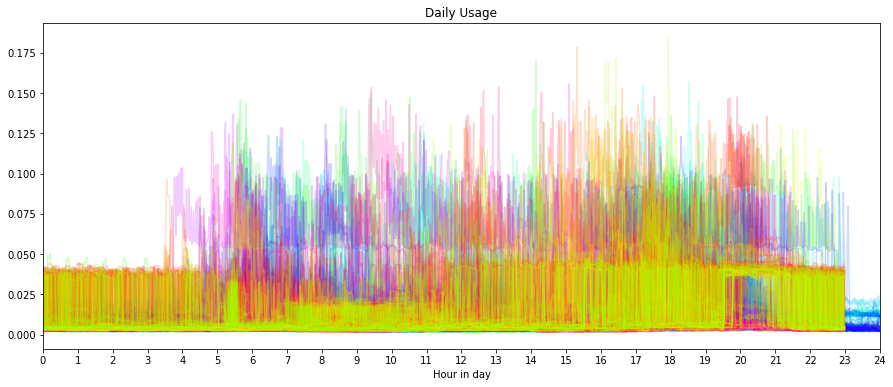

In [140]:
ax = plotDailySolar(df3, 'D', k='Usage')
ax.set_title('Daily Usage')
ax.set_xticks(range(0,24+1))
ax.set_xlim(0,24)

(0, 24)

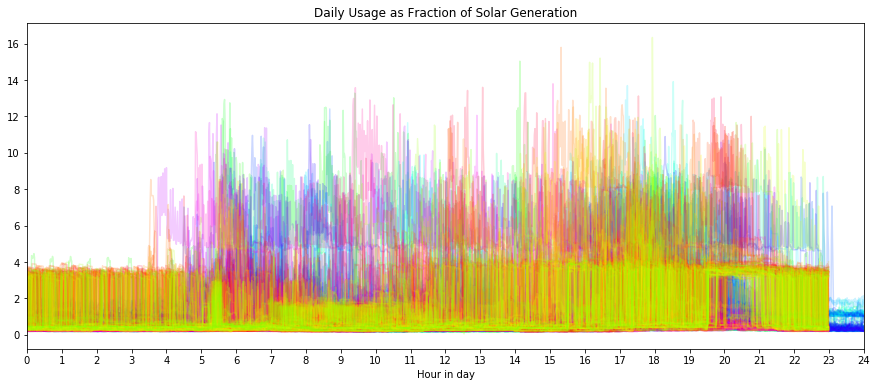

In [144]:
ax = plotDailySolar(df3, 'D', k='Usage [norm]')
ax.set_title('Daily Usage as Fraction of Solar Generation')
ax.set_xticks(range(0,24+1))
ax.set_xlim(0,24)

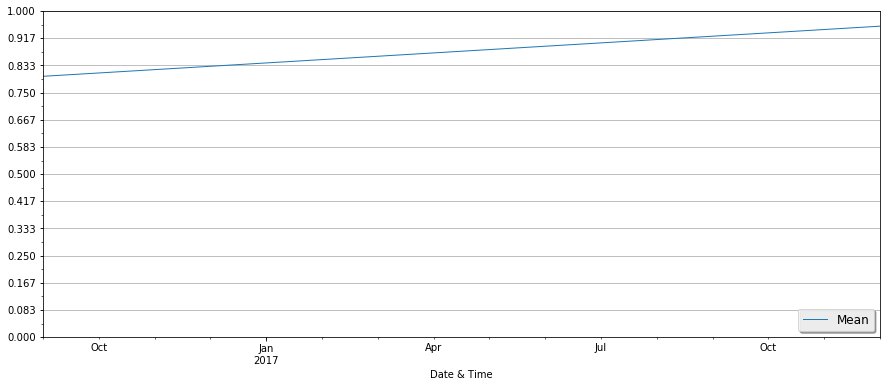

In [149]:
fig, ax = plt.subplots(figsize=(15,6))
df4 = df3.groupby(pandas.TimeGrouper('15M'))
df4['Usage [norm]'].mean().plot(ax=ax, label='Mean', linewidth=1) #c='#7fa7ff', 
#df4['Solar [norm]'].max().plot(ax=ax, label='Max', c='#c771fc', linewidth=1)
#solar_max = df4['Solar'].sum()
#solar_max.apply(lambda x: x / solar_max.max()).plot(ax=ax, label='Daily', c='blue')
#df4['Solar [norm]'].apply(lambda column: (column > 0).sum() / len(column)).plot(ax=ax, label='Daylight', linewidth=3, c='#333333')

plt.ylim(0,1)
ax.set_yticks(pandas.np.linspace(0,1,12+1), False)
ax.set_yticks(pandas.np.linspace(0,1,24+1),True)
ax.grid(which='major', axis='y')

#ax.xaxis.set_major_locator(mdates.MinuteLocator())
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
legend = ax.legend(loc='lower right', shadow=True, fontsize='large')

In [152]:
pandas.TimeGrouper??